In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
from pathlib import Path

sys.path.append(str(Path().cwd().parent))

In [3]:
import matplotlib.pyplot as plt

import load_dataset
import plotting

In [4]:
dataset = load_dataset.Dataset('../data/dataset/')

## Разбор (не запускать ячейки)

### Выгрузим временной ряд индекса Доу-Джонса, один из ярких примеров рядов, который, будучи случайным блужданием, очень сложно предсказать лучше наивного метода.

In [5]:
ts = dataset['dow_jones_3.csv']

<AxesSubplot:xlabel='2018-11-30'>

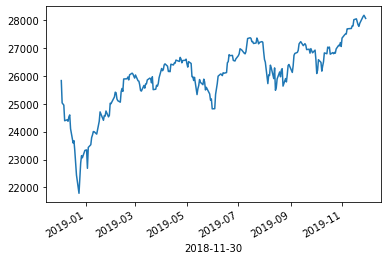

In [6]:
ts.plot()

In [7]:
len(ts)

250

### Разобьем ряд на трейн и тест и попробуем зафитить нашу "сложную" ML модель TimeSeriesPredictor с базой в виде линейной регрессии.

In [64]:
ts_train, ts_test = ts[:200], ts[200:]

In [10]:
from model import TimeSeriesPredictor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression

predictor = TimeSeriesPredictor(
    num_lags=12,
    granularity='P1D',
    model=LinearRegression
)

In [11]:
predictor.fit(ts_train)

### Сделаем one step ahead предсказания на тесте, предсказание выглядит неплохо.

In [12]:
preds = predictor.predict_batch(ts_train, ts_test)

In [24]:
predictor.get_params()

{'granularity': 'P1D',
 'mappers': {},
 'model__copy_X': True,
 'model__fit_intercept': True,
 'model__n_jobs': None,
 'model__normalize': False,
 'model': LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
          normalize=False),
 'num_lags': 12}

<AxesSubplot:xlabel='2018-11-30'>

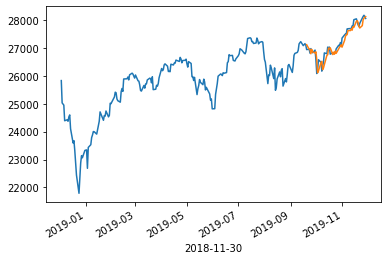

In [16]:
# кажется, получилось весьма неплохо
ts.plot()
preds.plot()

### Давайте посмотрим на абсолютные метрики.

In [25]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [26]:
mean_squared_error(preds, ts_test)

32553.100514271213

In [27]:
mean_absolute_error(preds, ts_test)

137.9848002737412

In [51]:
# выдать какой-то вердикт по ним, впрочем, сложно

### Остатки тоже выглядят неплохо

<AxesSubplot:xlabel='2018-11-30'>

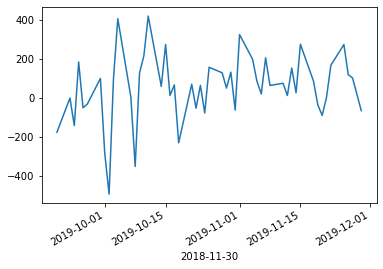

In [28]:
(ts_test-preds).plot()

### Дикки-Фуллер говорит о стационарности остатков.

In [31]:
def test_adfuler(data):
    test = adfuller(data.dropna())
    print ('adf: ', test[0])
    print ('p-value: ', test[1])
    print ('Critical values: ', test[4])
    if test[0]> test[4]['5%']: 
        print ('есть единичные корни, ряд не стационарен')
    else:
        print ('единичных корней нет, ряд стационарен')

In [30]:
from statsmodels.tsa.stattools import adfuller
adfuller(ts_test-preds)[1]

0.035026145165845186

In [32]:
test_adfuler(ts_test-preds)

adf:  -2.9985915087126487
p-value:  0.035026145165845186
Critical values:  {'1%': -3.584828853223594, '5%': -2.9282991495198907, '10%': -2.6023438271604937}
единичных корней нет, ряд стационарен


### По всем признакам, мы получили неплохую модель. Пора выкатывать на прод!

### А теперь давайте сравним с наивным предсказанием.

In [77]:
from metrics import mase

In [78]:
mase(preds, ts_test, method='naive')

1.100786870293897

### Модель показывает себя на 10% хуже наивного предсказания! 

![img](../data/images/directed.jpg)

## Задание

Реализуйте метрику MASE, которая записывается, как  
`mase = MAE(y_pred, y_true) / MAE(y_reference, y_true)`, где  
`y_pred` - one step ahead предсказания вашей модели на некой тестовой выборке  
`y_true` - реальные значения тестовой выборки  
`y_reference` - предсказания сравниваемой модели на той же тестовой выборке  


* чтобы получить y_reference для наивного метода, достаточно только сдвинуть y_true (потерей одной точки в данном задании перенебрегаем
* чтобы получить y_reference для всех остальных методов, необходимо передать в функцию историю ряда до y_true.
* реализацию методов mean, median можете сделать как на всем ts, так и на произвольном скользящем окне по вашему усмотрению

In [60]:
import pandas as pd

In [79]:
def mase(y_pred, y_true, method='naive', ts=None):
    """
    Реализуйте метрику mase для сравнения предсказаний y_pred вашего метода и y_method, являющегося
    предсказанием метода, указанного в параметре method.
    
    Формула для расчета mase = MAE(y_pred, y_true) / MAE(y_reference, y_true), 
    где MAE - mean absolute error - средняя абсолютная ошибка.
    
    В качестве method реализуйте поддержку {'naive', 'mean', 'median'}.
    
    Для наивного метода достаточно использовать только y_true.
    Для методов средней и медианы понадобится использовать временной ряд ts.
    
    """
    
    from sklearn.metrics import mean_absolute_error as MAE
    
    # return MAE(y_pred, y_true)/MAE(y_true.shift(1).dropna(), y_true[1:]) #убираем NaN
    y_reference = y_true.shift(1)
    # y_reference[0] = ts[-1:]
    y_reference[0] = y_pred.mean()
    return MAE(y_pred, y_true)/MAE(y_reference, y_true)

In [49]:
mase(preds, ts_test)

1.1200150489045757

In [75]:
mase(preds, ts_test, ts=ts_train)

1.1134140993586936

In [80]:
mase(preds, ts_test)

1.1069572319411054